# Проект спринта "Численные методы"
# Название: "Исследование факторов, влияющих на стоимость подержанных авто"

## Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.
Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

## Цели
- Изучить влияние факторов на стоимость автомобилей, найти наиболее значимые из предоставленных признаков
- Построить простые модели машинного обучения (случайный лес, дерево решений, линейная регрессия). Выбрать лучшую модель по метрике RMSE
- Построить модель с использованием градинетного бустинга 
- Проанализировать скорость работы каждой модели
- Выбрать наилучшую модель

## Инструкция по выполнению проекта
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.
- Загрузите и подготовьте данные.
- Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
- Проанализируйте скорость работы и качество моделей.
#### Примечания:
Для оценки качества моделей применяйте метрику RMSE.
Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:

#### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
#### Целевой признак
- Price — цена (евро)

## Загрузка и подготовка данных 

### Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math


from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [2]:
!pip install lightgbm

In [3]:
import lightgbm as lgb

In [4]:
!pip install catboost

In [5]:
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

In [6]:
from numpy.random import RandomState
rdm = RandomState(1234)

In [7]:
data = pd.read_csv('/datasets/autos.csv')

Ипользую данный параметр,для проверки работы модели. С полноценным  датасетом время работы модели возрастает до нескольких десятков минут

In [8]:
#nrows = 10000 - для предобработки данных загружается выделенное количество строк для экономии места

Вызовем 5 случайных строк из датасета для общего понимания данных

In [9]:
data.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
187229,2016-03-22 14:50:40,1200,NaN,2000,manual,0,calibra,150000,6,petrol,opel,NaN,2016-03-22 00:00:00,0,17036,2016-04-02 06:18:13
269079,2016-03-08 08:36:42,1000,bus,1999,manual,120,ducato,150000,10,gasoline,fiat,no,2016-03-08 00:00:00,0,83104,2016-03-21 18:46:10
173275,2016-03-12 21:54:20,4500,convertible,2005,manual,136,3_reihe,150000,1,petrol,peugeot,no,2016-03-12 00:00:00,0,26954,2016-04-05 17:21:43
133363,2016-03-15 20:48:08,990,sedan,1996,manual,136,e_klasse,150000,12,petrol,mercedes_benz,no,2016-03-15 00:00:00,0,20457,2016-03-15 20:48:08
8920,2016-03-09 20:58:03,4300,sedan,2007,manual,177,auris,150000,4,gasoline,toyota,no,2016-03-09 00:00:00,0,86199,2016-03-29 10:18:02


In [10]:
data.shape

(354369, 16)

Удалим колонки, которые не оказывают сильный результат на работу моделей. Для расчета стоимости автомобиля неважен почтовый индекс,количество фотографий (там везде значение 0), дата создания анкеты, дата скачивания анкеты из базы, а также время последнего посещения сайта. Также  я удалила месяц регистрации автомобиля,т.к. по итогам анализа(и заполнения пропусков самым частым значением) этот параметр  получил очень высокую значимость. Данный результат выглядит аномальным. Предположим, что месяц регистрации автомобиля  не вносит существенный вклад в стоимость автомобиля. 

In [11]:
#data = data.drop(columns = ['PostalCode'],axis = 1) 
#data = data.drop(['NumberOfPictures', 'DateCrawled', 'DateCreated','LastSeen','RegistrationMonth'], axis=1).head()
data = data.drop(columns = ['NumberOfPictures'],axis = 1) #поскольку везде нулевые значения 
data = data.drop(columns = ['DateCrawled'],axis = 1) #эта и другие даты не влияют  на стоимость
data = data.drop(columns = ['DateCreated'],axis = 1)
data = data.drop(columns = ['LastSeen'],axis = 1)
data = data.drop(columns = ['RegistrationMonth'],axis = 1)

Приведем название столбцов к змеиному регистру

In [12]:
data = data.rename(columns = { 
                       "Price": "price",
                       "VehicleType": "vehicle_type",
                       "RegistrationYear": "registration_year",
                       "Gearbox": "gear_box",
                       "Power": "power",
                       "Model": "model",
                       "Kilometer":"kilometer",
                       "FuelType": "fuel_type",
                       "Brand": "brand",
                       "NotRepaired": "is_repaired"
                       })

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gear_box           334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   is_repaired        283215 non-null  object
 10  PostalCode         354369 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


Сократим обьем используемой памяти засчет изменения типа данных

 ## Анализ пропусков, дубликатов и выбросов в колонках датафрейма

In [14]:
data.describe()

,price,registration_year,power,kilometer,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,99998.000000


Видим аномальные значения в столбцах стоимости (0), год регистрации (1000 и 9999), кол-во лошадиных сил (0)

Запишем функцию для анализа колонок датафрейма

In [15]:
def data_describe (data:pd.DataFrame, colname: str):
    print (f"Количество пропусков:{sum(data[colname].isna())}")
    print (f"Тип переменной {data.dtypes[colname]}")
    print (f"Количество уникальных значений {data[colname].value_counts()}")

Запишем построение диаграммы столбца датафрейма

In [16]:
def hist (x:pd.Series):
    plt.figure()
    plt.hist(x,edgecolor = 'black',color  = 'skyblue') #добавление черной границы столбца
    plt.grid()

 ### price

Посмотрим на целевой признак датасета

Количество пропусков:0
Тип переменной int64
Количество уникальных значений 0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64


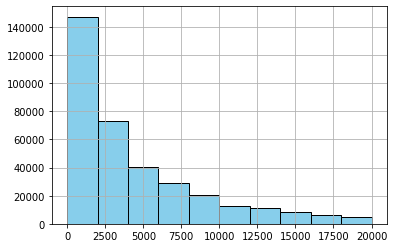

In [17]:
data_describe(data,'price')
hist (data['price'])

<div style="border:solid green 2px; padding: 20px">
Вывод: на гистограмме видим большое количество нулевых значений стоимости, рассмотрим далее их подробнее. Также посмотрим на "хвост" с высокой стоимостью автомобилей в датасете. В данных нет пропусков, поэтому будем заниматься только аномальными значениями в данном столбце

Найдем у признака price по 5 процентов от самой минимальной стоимостии от максимальной

In [18]:
print(np.quantile(data["price"], 0.05))

print(np.quantile(data["price"], 0.95))

200.0
14600.0


Посмотрим количество данных, у которых стоимость меньше пяти процентов начальной стоимости

In [19]:
df_sbs = data[data["price"] < np.quantile(data["price"], 0.05)]
df_sbs

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,fuel_type,brand,is_repaired,PostalCode
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,19348
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN,56412
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN,53721
79,150,NaN,2016,manual,75,astra,150000,petrol,opel,yes,78315
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no,40589
...,...,...,...,...,...,...,...,...,...,...,...
354273,150,small,1993,manual,55,astra,150000,petrol,opel,yes,66424
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes,22559
354309,99,small,1999,manual,60,arosa,150000,petrol,seat,yes,91301
354338,180,NaN,1995,NaN,0,NaN,125000,petrol,opel,NaN,41470


<div style="border:solid green 2px; padding: 20px">
Вывод: Мы видим, что таких данных достаточно много -- больше 17 тыс.

Посмотрим на нулевые показатели стоимости автомобилей 

In [20]:
df_sbs = data[data["price"] == 0]
df_sbs

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,fuel_type,brand,is_repaired,PostalCode
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,19348
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN,56412
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN,21698
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN,37520
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes,27432
...,...,...,...,...,...,...,...,...,...,...,...
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes,23758
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN,33659
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN,42329
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes,22559


In [21]:
df_sbs = data[data["price"] == 1]
df_sbs

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,fuel_type,brand,is_repaired,PostalCode
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN,53721
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no,40589
268,1,sedan,1990,manual,90,80,70000,petrol,audi,no,55122
408,1,NaN,2000,NaN,75,golf,90000,petrol,volkswagen,NaN,78588
901,1,NaN,1990,manual,0,other,150000,NaN,porsche,NaN,65843
...,...,...,...,...,...,...,...,...,...,...,...
353252,1,coupe,1990,manual,45,polo,150000,petrol,volkswagen,no,26160
353584,1,NaN,2000,NaN,0,NaN,10000,NaN,sonstige_autos,NaN,52525
353682,1,bus,1999,manual,0,espace,150000,petrol,renault,NaN,57439
353727,1,NaN,2000,NaN,0,NaN,150000,NaN,bmw,NaN,42329


<div style="border:solid green 2px; padding: 20px">
Вывод: не наблюдается закономерностей между значеняими стоимости 0 и 1 , значит просто отбросим пятипроцентные "хвосты данных" в столбце  price

Отделим данные согласно полученным значениям пятипроцентного квантиля 
200.0 и 
14600.0

In [22]:
df_sbs = data[data["price"] > 500]
df_sbs = df_sbs[df_sbs["price"]< 14600]
df_sbs

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,fuel_type,brand,is_repaired,PostalCode
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,67112
...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,26624
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,39576
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,26135
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,87439


Найдем среднюю стоимость автомобиля

In [23]:
data = df_sbs
data['price'].mean()

4247.836414687411

In [25]:
data.describe()

,price,registration_year,power,kilometer,PostalCode
count,294892.000000,294892.000000,294892.000000,294892.000000,294892.000000
mean,4247.836415,2003.882265,111.812704,129929.109640,50729.602298
std,3494.615491,61.919019,190.511807,35586.475261,25654.978015
min,501.000000,1000.000000,0.000000,5000.000000,1067.000000
25%,1499.000000,1999.000000,75.000000,125000.000000,30519.000000
50%,3000.000000,2003.000000,105.000000,150000.000000,49586.000000
75%,6199.000000,2007.000000,141.000000,150000.000000,71131.000000
max,14599.000000,9999.000000,20000.000000,150000.000000,99998.000000


In [26]:
data.isna().sum()

price                    0
vehicle_type         25670
registration_year        0
gear_box             12617
power                    0
model                13661
kilometer                0
fuel_type            21994
brand                    0
is_repaired          51775
PostalCode               0
dtype: int64

### registration_year

Количество пропусков:0
Тип переменной int64
Количество уникальных значений 2005    20600
2000    19201
2003    18996
2004    18957
2006    18844
        ...  
5555        1
5300        1
8888        1
7100        1
2290        1
Name: registration_year, Length: 124, dtype: int64


,price,registration_year,power,kilometer,PostalCode
count,294892.000000,294892.000000,294892.000000,294892.000000,294892.000000
mean,4247.836415,2003.882265,111.812704,129929.109640,50729.602298
std,3494.615491,61.919019,190.511807,35586.475261,25654.978015
min,501.000000,1000.000000,0.000000,5000.000000,1067.000000
25%,1499.000000,1999.000000,75.000000,125000.000000,30519.000000
50%,3000.000000,2003.000000,105.000000,150000.000000,49586.000000
75%,6199.000000,2007.000000,141.000000,150000.000000,71131.000000
max,14599.000000,9999.000000,20000.000000,150000.000000,99998.000000


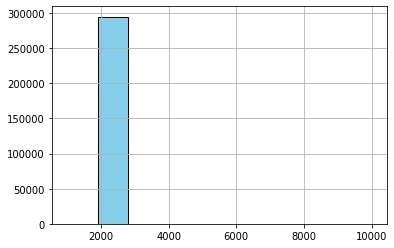

In [27]:
data_describe(data,'registration_year' )
hist(data['registration_year'])
data.describe()

<div style="border:solid green 2px; padding: 20px">
Вывод: пропусков нет, будем работать над устранением аномальных значений

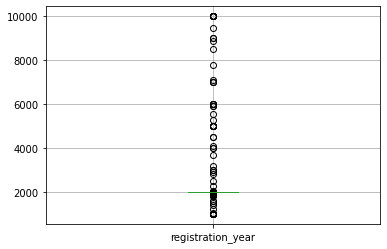

In [28]:
data.boxplot(column='registration_year')
plt.show()

In [29]:
df_sbs = data[data["registration_year"] > 1966]
df_sbs = df_sbs[df_sbs["registration_year"]< 2016]
df_sbs

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,fuel_type,brand,is_repaired,PostalCode
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,67112
...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,26624
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN,39576
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,26135
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,87439


In [30]:
df_sbs['registration_year'].value_counts()

2005    20600
2000    19201
2003    18996
2004    18957
2006    18844
1999    18825
2001    18343
2002    18038
2007    15749
1998    14035
2008    13618
2009    12619
1997    10263
2010     8545
1996     7548
2011     7241
1995     5833
2012     4896
1994     3354
2013     2472
1993     2351
1992     2228
1991     2061
1990     1902
2014     1335
1989     1055
1988      803
2015      562
1985      549
1987      546
1986      444
1980      388
1983      360
1984      359
1982      284
1979      244
1978      235
1981      220
1970      206
1972      162
1977      150
1974      142
1976      136
1973      133
1971      128
1975      116
1969       91
1968       84
1967       71
Name: registration_year, dtype: int64

In [31]:
df_sbs_1 = data[data["registration_year"] < 1966]
df_sbs_1

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,fuel_type,brand,is_repaired,PostalCode
1794,12800,coupe,1965,manual,90,other,100000,petrol,ford,no,12049
1928,7000,suv,1945,manual,48,other,150000,petrol,volkswagen,no,58135
2262,6500,convertible,1965,auto,360,NaN,150000,petrol,sonstige_autos,NaN,67105
2273,1800,convertible,1925,NaN,0,NaN,5000,NaN,sonstige_autos,no,79288
3333,10500,sedan,1955,manual,30,other,60000,petrol,ford,NaN,53498
...,...,...,...,...,...,...,...,...,...,...,...
351299,5500,bus,1956,manual,37,NaN,60000,petrol,sonstige_autos,no,1900
351682,11500,NaN,1800,NaN,16,other,5000,petrol,fiat,NaN,16515
352529,10000,sedan,1961,manual,80,other,125000,petrol,volvo,no,71334
353531,6000,sedan,1937,manual,38,other,5000,petrol,mercedes_benz,NaN,23936


In [32]:
df_sbs[df_sbs["brand"] == 'sonstige_autos']

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,fuel_type,brand,is_repaired,PostalCode
431,3950,small,2004,auto,5,NaN,70000,gasoline,sonstige_autos,no,90562
661,9900,suv,2000,auto,250,NaN,150000,lpg,sonstige_autos,no,17309
700,6999,sedan,2010,auto,186,NaN,125000,petrol,sonstige_autos,no,81929
999,3900,wagon,1990,manual,0,NaN,30000,petrol,sonstige_autos,NaN,15345
1098,11500,bus,1985,auto,160,NaN,125000,petrol,sonstige_autos,NaN,4849
...,...,...,...,...,...,...,...,...,...,...,...
353892,7900,bus,2009,NaN,140,NaN,125000,gasoline,sonstige_autos,no,97256
354062,6000,small,2008,manual,155,NaN,150000,petrol,sonstige_autos,no,63069
354073,1750,NaN,1995,NaN,0,NaN,100000,NaN,sonstige_autos,NaN,6188
354321,9400,wagon,2007,manual,200,NaN,150000,gasoline,sonstige_autos,yes,91186


Мы видим, что значения меньше 1941 года выглядят аномальными в датасете (либо стоимость неподходящая, либо модель, которой еще не существовало. Также непонятным остаются значения sonstige_autos -- их довольно много(2312 шт). Гугл показывает, что это погрузочная платформа для авто. Такие средства передвижения  не входят в задачи нашего исследования, поэтому удалим данные значения тоже. 

In [33]:
data = df_sbs[df_sbs["brand"] != 'sonstige_autos']
data

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,fuel_type,brand,is_repaired,PostalCode
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,67112
...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,96465
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,26624
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,26135
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,87439


In [34]:
data.isna().sum()

price                    0
vehicle_type          6471
registration_year        0
gear_box              9885
power                    0
model                 9044
kilometer                0
fuel_type            14386
brand                    0
is_repaired          42846
PostalCode               0
dtype: int64

In [35]:
data.describe()

,price,registration_year,power,kilometer,PostalCode
count,273427.000000,273427.000000,273427.000000,273427.000000,273427.000000
mean,4319.256675,2002.470886,113.648528,130015.525168,50924.257081
std,3515.976410,5.816299,186.853100,35218.996092,25666.956086
min,501.000000,1967.000000,0.000000,5000.000000,1067.000000
25%,1500.000000,1999.000000,75.000000,125000.000000,30823.000000
50%,3100.000000,2003.000000,105.000000,150000.000000,49808.000000
75%,6300.000000,2006.000000,143.000000,150000.000000,71364.000000
max,14599.000000,2015.000000,20000.000000,150000.000000,99998.000000


 ### power

Количество пропусков:0
Тип переменной int64
Количество уникальных значений 0        21606
75       18366
150      12515
101      11245
60       11185
         ...  
952          1
20000        1
953          1
297          1
16311        1
Name: power, Length: 601, dtype: int64


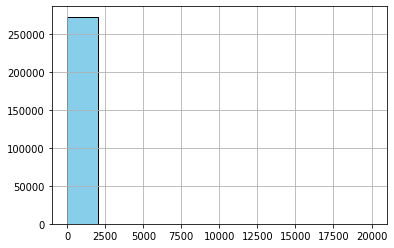

In [36]:
data_describe(data,'power')
hist(data['power'])

In [37]:
print(np.quantile(data["power"], 0.05))

print(np.quantile(data["power"], 0.99))

0.0
286.0


Ограничим нижний порог мощности 40 л.с.

In [38]:
df_sbs = data[data["power"] > 40] 
df_sbs = df_sbs[df_sbs["power"] < 200]
df_sbs

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,fuel_type,brand,is_repaired,PostalCode
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no,67112
...,...,...,...,...,...,...,...,...,...,...,...
354358,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no,48653
354359,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no,75223
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,26135
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,87439


In [39]:
data = df_sbs
data.isna().sum()

price                    0
vehicle_type          2984
registration_year        0
gear_box              3672
power                    0
model                 6496
kilometer                0
fuel_type             9288
brand                    0
is_repaired          30479
PostalCode               0
dtype: int64

In [40]:
data = df_sbs
data.describe()

,price,registration_year,power,kilometer,PostalCode
count,233574.000000,233574.000000,233574.000000,233574.000000,233574.000000
mean,4180.152496,2002.654902,111.229520,129356.863350,51217.208675
std,3383.284199,5.686811,37.525109,35288.325019,25662.199788
min,501.000000,1967.000000,41.000000,5000.000000,1067.000000
25%,1500.000000,1999.000000,75.000000,125000.000000,30982.000000
50%,3000.000000,2003.000000,109.000000,150000.000000,50321.000000
75%,5999.000000,2007.000000,140.000000,150000.000000,71665.000000
max,14599.000000,2015.000000,199.000000,150000.000000,99998.000000


Отбросим 1 процент среди максимальных значений данных, тем самым уберем  аномальное количество л.с. (максимум в мире 2000 тыс)

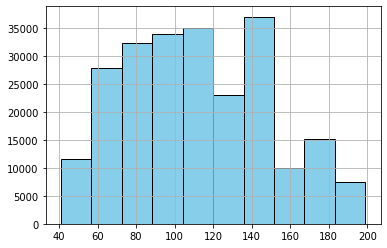

In [41]:
hist (data["power"])

In [42]:
data.isna().sum()

price                    0
vehicle_type          2984
registration_year        0
gear_box              3672
power                    0
model                 6496
kilometer                0
fuel_type             9288
brand                    0
is_repaired          30479
PostalCode               0
dtype: int64

### Категориальные переменные vehicle_type, gear_box, model, fuel_type, brand, is_repaired

Рассмотрим категориальные данные в нашем датасете. Вызываем describe, куда включены типы данных 'object'и 'bool'

In [43]:
data.describe(include=['object','bool'])

,vehicle_type,gear_box,model,fuel_type,brand,is_repaired
count,230590,229902,227078,224286,233574,203095
unique,8,2,244,7,39,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,66090,192959,20046,148982,52598,183804


В данной таблице хорошо видны наиболее популярные упоминания параметров столбца. Например самый популряный тип кузова -- это седан, а самый популяряный бренд -- фольцваген

Посмотрим количество пропуско в датасете

In [44]:
data.isna().sum()

price                    0
vehicle_type          2984
registration_year        0
gear_box              3672
power                    0
model                 6496
kilometer                0
fuel_type             9288
brand                    0
is_repaired          30479
PostalCode               0
dtype: int64

In [45]:
data.isna().sum()

price                    0
vehicle_type          2984
registration_year        0
gear_box              3672
power                    0
model                 6496
kilometer                0
fuel_type             9288
brand                    0
is_repaired          30479
PostalCode               0
dtype: int64

заменим типа данных столбца is_repaired, чтобы обработать его отдельно за рамками цикла, организованно для других категориальных признаков

Разделим колонки на категориальные и количественные

In [46]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']

print (categorical_columns)
print (numerical_columns)

['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand', 'is_repaired']
['price', 'registration_year', 'power', 'kilometer', 'PostalCode']


посмотрим значения  всех категориальных переменных

In [47]:
for c in categorical_columns:
    print (data[c].unique())

['suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe' 'other' nan]
['auto' 'manual' nan]
['grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'twingo' 'a_klasse' 'scirocco' '5er' 'civic' 'transporter' 'punto'
 'e_klasse' 'kadett' 'other' 'one' 'fortwo' 'clio' '1er' 'b_klasse'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' 'escort' 'forester'
 'xc_reihe' 'scenic' 'a1' 'focus' 'a4' 'a6' 'jazz' 'polo' 'slk' 'combo'
 '80' nan '147' 'z_reihe' 'sorento' 'ibiza' 'eos' 'astra' 'touran' 'getz'
 'insignia' 'ka' 'megane' 'a3' 'lupo' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' '7er' 'tiguan' 'tt' '6_reihe' 'c4' 'panda'
 'up' 'i_reihe' 'ceed' 'kangoo' 'yeti' 'octavia' 'zafira' 'mii' 'rx_reihe'
 'corsa' 'fox' 'matiz' 'beetle' 'rio' 'logan' 'spider' 'omega' 'cuore'
 's_max' 'modus' 'a2' 'c3' '1_reihe' 'sharan' 'avensis' 'roomster'
 'kaefer' 'santa' 'cooper' '4_reihe' 'sportage' 'laguna' 'ptcruiser' 'clk'
 'primera' 'espace' 's_klasse' 'galaxy' '159' 't

Заполнение пропусков в категориальных признаках самым популярным значением столбца

In [48]:
data['is_repaired'].value_counts() 
#уникальные значения столбца и их количество, normalize = True - получим процнты, разделив на общее количество

no     183804
yes     19291
Name: is_repaired, dtype: int64

In [49]:
data.loc[data.loc[:,"kilometer"] >=100000]['is_repaired'].count()

165541

In [50]:
#data[data['kilometer']>=100000]

In [51]:
data.loc[data['kilometer']>= 100000,'is_repaired'] = 'yes'

In [52]:
data['is_repaired'].value_counts() 
#уникальные значения столбца и их количество, normalize = True - получим процнты, разделив на общее количество

yes    194455
no      35426
Name: is_repaired, dtype: int64

In [53]:
data_describe = data.describe(include=[object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])

In [54]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']

print (categorical_columns)
print (numerical_columns)

['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand', 'is_repaired']
['price', 'registration_year', 'power', 'kilometer', 'PostalCode']


In [55]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gear_box             0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
is_repaired          0
PostalCode           0
dtype: int64

Посмотрим количество дубликатов в датасете

In [56]:
data.duplicated().sum()

20215

In [57]:
data = data.drop_duplicates().reset_index(drop = True)

In [58]:
data.corr()

,price,registration_year,power,kilometer,PostalCode
price,1.000000,0.580713,0.374197,-0.385432,0.053094
registration_year,0.580713,1.000000,0.077128,-0.343712,0.024961
power,0.374197,0.077128,1.000000,0.186995,0.051091
kilometer,-0.385432,-0.343712,0.186995,1.000000,-0.011072
PostalCode,0.053094,0.024961,0.051091,-0.011072,1.000000


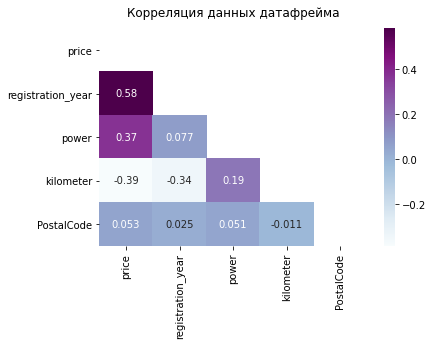

In [59]:
mask = np.triu (np.ones_like (data.corr ()))
heatmap = sns.heatmap(data.corr(), annot = True,cmap='BuPu',mask = mask)
heatmap.set_title('Корреляция данных датафрейма', fontdict={'fontsize':12}, pad=12);

<div style="border:solid green 2px; padding: 20px">
Вывод: Наблюдается сильная корреляция между признаками registration year и price (0.58) и между power и price (0.37)

In [60]:
data_brand = data.groupby(['brand'])[["price"]].mean()
display(data_brand)

,price
brand,
alfa_romeo,3669.453125
audi,5091.864580
bmw,5122.004487
chevrolet,4803.862692
chrysler,2873.405777
citroen,3757.124305
dacia,5851.857143
daewoo,1264.630508
daihatsu,2383.121560


In [61]:
data.groupby(['brand'])[["price"]].mean().loc['volvo'] #обратились к конкретному элементу в отсортированной таблице


price    3946.320706
Name: volvo, dtype: float64

In [62]:
data.pivot_table(index = ['brand'], values = ['price'],columns = ['is_repaired'], aggfunc = 'count')

price       
is_repaired      no    yes
brand                     
alfa_romeo      188   1284
audi           1131  15543
bmw            1356  19817
chevrolet       432    675
chrysler         52    675
citroen         772   2647
dacia           373    334
daewoo           58    237
daihatsu        112    324
fiat           1551   4158
ford           2633  12368
honda           326   1541
hyundai         902   1645
jaguar            8     96
jeep             33    263
kia             479   1160
lada             88     57
lancia           56    220
land_rover       16    290
mazda           623   3020
mercedes_benz  1490  17039
mini            816   1360
mitsubishi      325   1549
nissan          583   2360
opel           3688  20238
peugeot        1500   6020
porsche          11     82
renault        1748   8714
rover            23    238
saab             12    308
seat            971   3491
skoda          1021   2976
smart          1691   2313
subaru           58    355
suzuki          530   1075
toyota          845   2635
trabant           6      7
volkswagen     5819  41992
volvo            90   1837

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

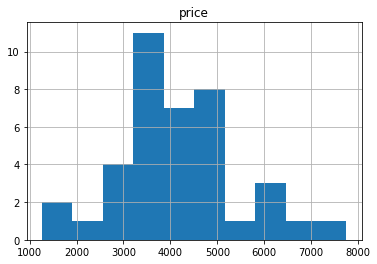

In [63]:
data_brand.hist()

<div class="alert alert-block alert-info">
    Вывод: Большая часть автомобилей имеют стоимость от 3 до 5 тысяч евро

<AxesSubplot:xlabel='brand'>

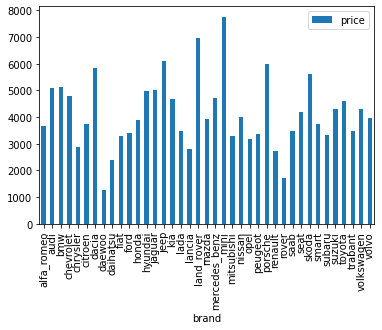

In [64]:
data_brand.reset_index().plot.bar(x='brand',y = 'price', rot = 90)

<div style="border:solid green 2px; padding: 20px">
    Вывод:  самая высокая стоимость у автомобилей марки mersedes_benz, land rover, dacia, Porsche
    

In [65]:
data['brand'].value_counts()

volkswagen       47811
opel             23926
bmw              21173
mercedes_benz    18529
audi             16674
ford             15001
renault          10462
peugeot           7520
fiat              5709
seat              4462
smart             4004
skoda             3997
mazda             3643
toyota            3480
citroen           3419
nissan            2943
hyundai           2547
mini              2176
volvo             1927
mitsubishi        1874
honda             1867
kia               1639
suzuki            1605
alfa_romeo        1472
chevrolet         1107
chrysler           727
dacia              707
daihatsu           436
subaru             413
saab               320
land_rover         306
jeep               296
daewoo             295
lancia             276
rover              261
lada               145
jaguar             104
porsche             93
trabant             13
Name: brand, dtype: int64

<AxesSubplot:>

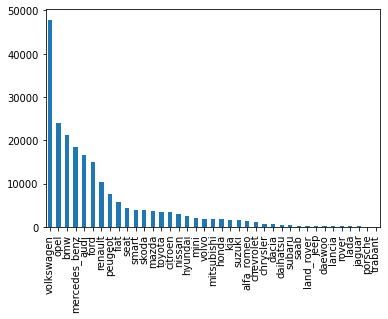

In [66]:
data['brand'].value_counts().plot.bar(x='brand', rot = 90)

<div style="border:solid green 2px; padding: 20px">
    Вывод:  Больше всего продается автомобилей марки volkswagen,меньше  всего trabant

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> ✔️ Отлично. Не хватает только вывода по итогам главы.
</div>

<div style="border:solid green 2px; padding: 20px">
    Вывод по итогам главы
    Мы провели предобработку данных, убрали аномальные значения колонках, заполнили пропуски, убрали ненужные столбцы

## Подготовка выборок к обучениею моделей

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213359 entries, 0 to 213358
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              213359 non-null  int64 
 1   vehicle_type       213359 non-null  object
 2   registration_year  213359 non-null  int64 
 3   gear_box           213359 non-null  object
 4   power              213359 non-null  int64 
 5   model              213359 non-null  object
 6   kilometer          213359 non-null  int64 
 7   fuel_type          213359 non-null  object
 8   brand              213359 non-null  object
 9   is_repaired        213359 non-null  object
 10  PostalCode         213359 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 17.9+ MB


Библиотека scikit-learn не умеет напрямую обрабатывать категориальные признаки. Поэтому прежде чем подавать данные на вход алгоритмов машинного обучения преобразуем категориальные признаки в количественные.

Категориальные признаки, принимающие два значения (т.е. бинарные признаки) и принимающие большее количество значений будем обрабатывать по-разному.

Выделим бинарные и небинарные признаки:

Значения бинарных признаков просто заменим на 0 и 1. Начнем с признака gear_box:

In [68]:
data.at[data['gear_box'] == 'manual', 'gear_box'] = 0
data.at[data['gear_box'] == 'auto', 'gear_box'] = 1
data['gear_box'].describe()

count     213359
unique         2
top            0
freq      179622
Name: gear_box, dtype: int64

In [69]:
data.at[data['is_repaired'] == 'no', 'is_repaired'] = 0
data.at[data['is_repaired'] == 'yes', 'is_repaired'] = 1
data['is_repaired'].describe()

count     213359
unique         2
top            1
freq      180943
Name: is_repaired, dtype: int64

In [70]:
data_describe = data.describe(include=[object])
data_describe

,vehicle_type,gear_box,model,fuel_type,brand,is_repaired
count,213359,213359,213359,213359,213359,213359
unique,8,2,244,7,39,2
top,sedan,0,golf,petrol,volkswagen,1
freq,63193,179622,24406,144497,47811,180943


Векторизация признаков с помощью get_dummies:

In [71]:
data['vehicle_type'] = pd.get_dummies(data['vehicle_type'],drop_first = True)
data['gear_box'] = pd.get_dummies(data['gear_box'],drop_first = True)
data['fuel_type'] = pd.get_dummies(data['fuel_type'],drop_first = True)

In [72]:
from sklearn.preprocessing import LabelEncoder
data['model'] = LabelEncoder().fit_transform(data['model'])
data['brand'] = LabelEncoder().fit_transform(data['brand'])

Oтдельно рассмотрим столбцы, соответствующие входным признакам (это будет матрица X), а отдельно – выделенный признак (вектор y):

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера:</b>  Интересное решение, но не проще было бы воспользоваться enconder, например OneHotEnconder.
</div>

<div class="alert alert-block alert-info">
    А это она и есть в нашем блоке обучения(см скрин), я пыталась по-другому ее понять, поэтому другая теория в пояснении

<div class="alert alert-success">
<b>Комментарий ревьюера v.2:</b> ✔️Я имел ввиду, что если его использовать, можно было быстрее сделать и чуть упростить себе задачу. </div>

In [73]:
X = data.drop(('price'), axis=1) # Выбрасываем столбец 'price'.
y = data['price']
feature_names = X.columns
print (feature_names)

Index(['vehicle_type', 'registration_year', 'gear_box', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'is_repaired', 'PostalCode'],
      dtype='object')


In [74]:
print (X.shape)
print (y.shape)

(213359, 10)
(213359,)


Разобьем выборку на обучающую и тестовую в соотношении 70/30

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(149351, 10)
(64008, 10)
(149351,)
(64008,)


In [76]:
from sklearn.preprocessing import StandardScaler # масштабирование признаков
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
numeric = ['registration_year','kilometer','power']
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

### Случайный лес (RandomForest)

In [77]:
%%time
model = RandomForestRegressor(random_state=12345, n_estimators=30)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
def rmse(y, predictions):
    return (((y_test-predictions)**2).mean())**0.5
RMSE_RF=rmse(y_test, predictions)
print("RMSE RF:",RMSE_RF)

RMSE RF: 1351.5678172765136
CPU times: user 16 s, sys: 194 ms, total: 16.2 s
Wall time: 16.2 s


## Анализ признаков, влияющих на стоимость автомобилей на основе обученной модели Случайного леса

In [78]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

Feature importances:
 1. feature 'registration_year' (0.5866)
 2. feature 'power' (0.1730)
 3. feature 'PostalCode' (0.0810)
 4. feature 'brand' (0.0520)
 5. feature 'model' (0.0485)
 6. feature 'kilometer' (0.0292)
 7. feature 'vehicle_type' (0.0151)
 8. feature 'is_repaired' (0.0077)
 9. feature 'gear_box' (0.0066)
10. feature 'fuel_type' (0.0001)


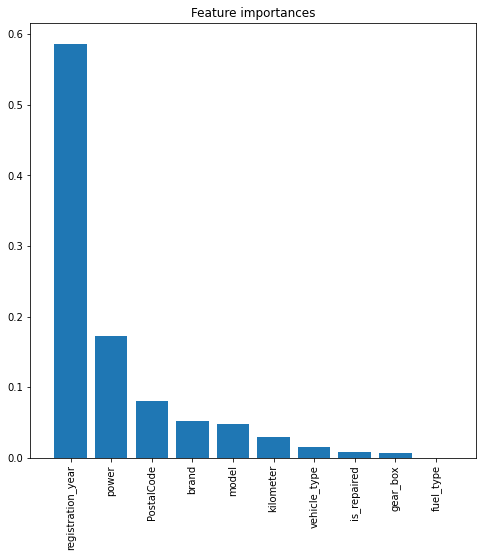

In [79]:
d_first = 10
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

<div style="border:solid green 2px; padding: 20px">
    Вывод:  Больше всего на стоимость влияет параметр "год регистрации". Это обьясняется высокой стоимостью раритетных автомобилей. Именно они вносят значительный  вклад во влияние года регистрации на стоимость автомобиля. На втором месте по влиянию на работу модели -- это мощность двигателя. Также достаточно сильное влияние оказал индекс (место нахождения авто) это важный параметр для больший стран, таких как Россия и США, в столицах цена определенно выше. Бренд не сильно влияет на стоимость авто, оказался на 4 месте рейтинга

### Линейная регрессия (Linear Regression)

In [80]:
%%time
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
def rmse(y, predictions):
    return (((y_test-predictions)**2).mean())**0.5
RMSE_LR = rmse(y_test, predictions)
print("RMSE LR:",RMSE_LR)

RMSE LR: 2277.0973502703796
CPU times: user 221 ms, sys: 145 ms, total: 366 ms
Wall time: 354 ms


###  Дерево решений (Decision Tree Regressor)

In [81]:
%%time
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state = 12345,max_depth=5)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
def rmse(y, predictions):
    return (((y_test-predictions)**2).mean())**0.5
RMSE_DT=rmse(y_test, predictions)
print("RMSE DT:",RMSE_DT)

RMSE DT: 1823.9904107956008
CPU times: user 349 ms, sys: 42.9 ms, total: 392 ms
Wall time: 435 ms


### Результаты работы моделей (Случайный лес, Дерево решений, Линейная регрессия)

In [82]:
result_simple_models = pd.Series({"RMSE RF":RMSE_RF,"RMSE DT":RMSE_DT,"RMSE LR":RMSE_LR})
result_simple_models

RMSE RF    1351.567817
RMSE DT    1823.990411
RMSE LR    2277.097350
dtype: float64

<div style="border:solid green 2px; padding: 20px">
Вывод: Показателем работы моделей (Случайный лес, дерево решений и линейная регрессия) стала метрика RMSE, это квадрат среднеквадратичного отклонения. Та модель обладает лучшими характеристиками, у которой RMSE меньше. Следовательно в нашем случае наилучший результат показала модель Случайного леса. RF: 1311.940010
DT: 1818.380732
LR: 1932.515789

## CatBoost

In [83]:
%%time
scoring_fit = 'neg_mean_squared_error'

cat_features = ['vehicle_type','gear_box','model','fuel_type','brand']

model_cat = CatBoostRegressor(cat_features=cat_features)
param_grid  = {'n_estimators':[50,100],
}
gs = GridSearchCV (model_cat,param_grid,cv = 5,scoring = scoring_fit)
fitted_cat = gs.fit(X_train,y_train,cat_features=cat_features)

pred = fitted_cat.predict(X_test) 
rmse_cat = (np.sqrt(mean_squared_error(y_test, pred))) 

print ("rmse при работе модели catboost", rmse_cat.round(2))


Learning rate set to 0.5
0:	learn: 2393.6105230	total: 82.8ms	remaining: 4.06s
1:	learn: 1989.1147052	total: 118ms	remaining: 2.83s
2:	learn: 1779.2037868	total: 150ms	remaining: 2.35s
3:	learn: 1669.4872396	total: 179ms	remaining: 2.06s
4:	learn: 1586.6743136	total: 212ms	remaining: 1.91s
5:	learn: 1551.0085639	total: 242ms	remaining: 1.77s
6:	learn: 1532.1586927	total: 271ms	remaining: 1.66s
7:	learn: 1518.2712980	total: 298ms	remaining: 1.56s
8:	learn: 1507.2057238	total: 325ms	remaining: 1.48s
9:	learn: 1499.6300674	total: 351ms	remaining: 1.4s
10:	learn: 1489.7324038	total: 380ms	remaining: 1.35s
11:	learn: 1478.0312804	total: 408ms	remaining: 1.29s
12:	learn: 1467.0872717	total: 435ms	remaining: 1.24s
13:	learn: 1460.9063430	total: 464ms	remaining: 1.19s
14:	learn: 1455.2176711	total: 492ms	remaining: 1.15s
15:	learn: 1448.6109788	total: 521ms	remaining: 1.11s
16:	learn: 1442.5176956	total: 549ms	remaining: 1.07s
17:	learn: 1434.1986088	total: 577ms	remaining: 1.02s
18:	learn: 14

In [84]:
print ("rmse при работе модели catboost", rmse_cat.round(2))

rmse при работе модели catboost 1345.9


<div class="alert alert-warning">
<b>Комментарий ревьюера v.2:</b> Это нужно было делать до разбиения по идеии </div>

## LGBM Regressor

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213359 entries, 0 to 213358
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              213359 non-null  int64 
 1   vehicle_type       213359 non-null  uint8 
 2   registration_year  213359 non-null  int64 
 3   gear_box           213359 non-null  uint8 
 4   power              213359 non-null  int64 
 5   model              213359 non-null  int64 
 6   kilometer          213359 non-null  int64 
 7   fuel_type          213359 non-null  uint8 
 8   brand              213359 non-null  int64 
 9   is_repaired        213359 non-null  object
 10  PostalCode         213359 non-null  int64 
dtypes: int64(7), object(1), uint8(3)
memory usage: 13.6+ MB


In [86]:
#код ревьюера(без этого LGBM не полетит)
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213359 entries, 0 to 213358
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              213359 non-null  int64   
 1   vehicle_type       213359 non-null  uint8   
 2   registration_year  213359 non-null  int64   
 3   gear_box           213359 non-null  uint8   
 4   power              213359 non-null  int64   
 5   model              213359 non-null  int64   
 6   kilometer          213359 non-null  int64   
 7   fuel_type          213359 non-null  uint8   
 8   brand              213359 non-null  int64   
 9   is_repaired        213359 non-null  category
 10  PostalCode         213359 non-null  int64   
dtypes: category(1), int64(7), uint8(3)
memory usage: 12.2 MB


In [88]:
data = data.astype ({"vehicle_type":'category',
                "gear_box":'category',
                "model":'category',
                "fuel_type":'category',
                "brand":'category',
                "is_repaired":'category',
                })

In [89]:
X = data.drop(('price'), axis=1) # Выбрасываем столбец 'price'.
y = data['price']
feature_names = X.columns
print (feature_names)

Index(['vehicle_type', 'registration_year', 'gear_box', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'is_repaired', 'PostalCode'],
      dtype='object')


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(149351, 10)
(64008, 10)
(149351,)
(64008,)


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213359 entries, 0 to 213358
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              213359 non-null  int64   
 1   vehicle_type       213359 non-null  category
 2   registration_year  213359 non-null  int64   
 3   gear_box           213359 non-null  category
 4   power              213359 non-null  int64   
 5   model              213359 non-null  category
 6   kilometer          213359 non-null  int64   
 7   fuel_type          213359 non-null  category
 8   brand              213359 non-null  category
 9   is_repaired        213359 non-null  category
 10  PostalCode         213359 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 9.6 MB


In [92]:
%%time

scoring_fit = 'neg_mean_squared_error'
model_LGBM = lgb.LGBMRegressor(random_state = 12345)
#param_grid  = {'n_estimators':[50,100],
              #'colsample_bytree':[0.7,0.8],
             #'max_depth':[5,10,12]}
#gs = GridSearchCV (model_LGBM,param_grid,cv = 5,scoring = scoring_fit)
#fitted_LGBM = gs.fit(X_train,y_train)
fitted_LGBM = model_LGBM.fit(X_train,y_train)
predictions = fitted_LGBM.predict(X_test)
def rmse(y, predictions):
    return (((y_test-predictions)**2).mean())**0.5
RMSE_LGBM=rmse(y_test, predictions)

print ('Параметры модели LGBM:', fitted_LGBM)
print("RMSE LGBM:",RMSE_LGBM)

Параметры модели LGBM: LGBMRegressor(random_state=12345)
RMSE LGBM: 1301.1751197547665
CPU times: user 1min 3s, sys: 407 ms, total: 1min 3s
Wall time: 1min 5s


## Общий вывод

In [93]:
#result_models = pd.concat([result_simple_models, rmse_cat,RMSE_LGBM], axis=0)
#result_models

In [95]:
result_models = pd.Series({"RMSE RF":RMSE_RF,"RMSE DT":RMSE_DT,"RMSE LR":RMSE_LR,'RMSE Catboost ':rmse_cat,"RMSE LGBM":RMSE_LGBM})
result_models

RMSE RF           1351.567817
RMSE DT           1823.990411
RMSE LR           2277.097350
RMSE Catboost     1345.897832
RMSE LGBM         1301.175120
dtype: float64

Подготовлены четыре модели предсказания стоимости автомобиля в зависисимости от параметров датасета. Оценка качества моделей производилась по метрике RMSE. Лучше всего себя показала модель случайного леса, у нее самый низкий показатель 

- RMSE LGBM: 1301 Wall time: 38.7 s
- RMSE Catboost - 1345  Wall time: 33.2 s
- RMSE Случайного леса - 1351 Wall time: 16.2 s
- Показатели работы других моделей представлены ниже
- RMSE Дерева решений - 1823 Wall time: 435 ms
- RMSE Линейной регресси - 2277 Wall time: 354 ms


По времени работы модель случайного леса оказалась наиболее долгой в работе

Перебор следующих парметров в модели дал наименьший результат RMSE, но занял значитльно большее время 

- 'n_estimators':[50,100],
  'colsample_bytree':[0.7,0.8],
  'max_depth':[5,10,12]}

RMSE LGBM: 1281.69733321696
CPU times: user 35min 3s, sys: 10.8 s, total: 35min 14s
Wall time: 35min 46s

Наблюдения: определение бОльшего количества параметров в категориальные признаки уменьшает RMSE на 80
Масштабирование признаков ухудшает показатель. Когда я проводила тест до масштабирования и  до  get_dummies, то RMSE LGBM был равен: 1281. Wall time: 38.7 s